Purpose of this notebook is calibrate camera. To obtain camera intrinsics and compare them between various scans.

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import skimage
import skimage.feature
from matplotlib.patches import Circle
from scipy.signal import find_peaks 

In [2]:
ROOT = "/Users/gimli/cvr/data/zavity/checkerboard"
assert os.path.isdir(ROOT)

In [3]:
cap = cv2.VideoCapture(os.path.join(ROOT, "GX010014.MP4"))

In [4]:
success, frame = cap.read()
gimg = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

## Preview and scale

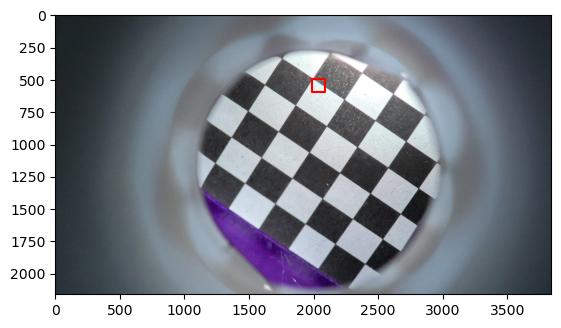

In [5]:
plt.figure()
plt.imshow(frame)
position = [1990, 490]
step = 100
plt.plot([position[0], position[0], position[0] + step, position[0] + step, position[0]], 
         [position[1], position[1] + step, position[1] + step, position[1], position[1]], color='red')
plt.show()

In [6]:
harris = cv2.cornerHarris(gimg, blockSize=100, ksize=31, k=0.01)

## Crop valid area

In [7]:
center = (gimg.shape[1]/2 + 110, gimg.shape[0]/2 + 110)
radius = 950

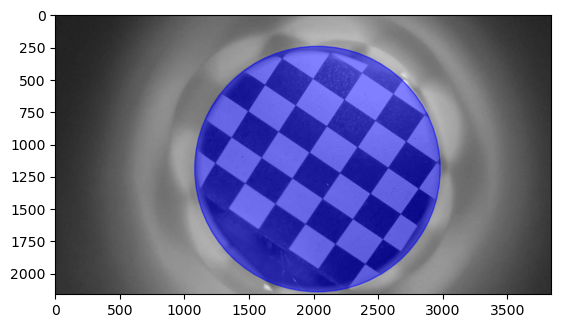

In [8]:
plt.figure()
ax = plt.subplot(111)
ax.imshow(gimg, cmap="gray")
circle = Circle(center, radius, color='blue', alpha=0.5)
ax.add_patch(circle)
plt.show()

In [9]:
cimg = np.copy(gimg)
xx, yy = np.meshgrid(np.arange(gimg.shape[1]), np.arange(gimg.shape[0]))
cimg[(xx - center[0]) ** 2 + (yy - center[1]) ** 2 > radius**2] = 0
crop_x = np.where(np.sum(cimg, axis=1) == 0)[0]
crop_y = np.where(np.sum(cimg, axis=0) == 0)[0]
cimg = cimg[np.max(crop_x[crop_x < center[0]]) : np.min(crop_x[crop_x > center[0]]),
            np.max(crop_y[crop_y < center[1]]) : np.min(crop_y[crop_y > center[1]])]
xx, yy = np.meshgrid(np.arange(cimg.shape[1]), np.arange(cimg.shape[0]))
radius -= 100

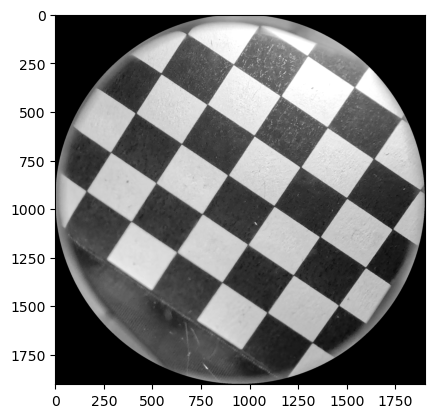

In [10]:
plt.imshow(cimg, cmap="gray")
plt.show()

In [11]:
def crop(img):
    gimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    CENTER = (gimg.shape[1] / 2 + 110, gimg.shape[0] / 2 + 110)
    RADIUS = 950
    
    cimg = np.copy(gimg)
    xx, yy = np.meshgrid(np.arange(gimg.shape[1]), np.arange(gimg.shape[0]))
    cimg[(xx - CENTER[0]) ** 2 + (yy - CENTER[1]) ** 2 > RADIUS ** 2] = 0
    crop_x = np.where(np.sum(cimg, axis=1) == 0)[0]
    crop_y = np.where(np.sum(cimg, axis=0) == 0)[0]
    return cimg[np.max(crop_x[crop_x < CENTER[0]]): np.min(crop_x[crop_x > CENTER[0]]),
           np.max(crop_y[crop_y < CENTER[1]]): np.min(crop_y[crop_y > CENTER[1]])]

## Harris

In [12]:
blur = cv2.GaussianBlur(cimg, [51, 51], 101)
harris = cv2.cornerHarris(blur, blockSize=100, ksize=31, k=0)
harris[(xx - harris.shape[1]/2) ** 2 + (yy - harris.shape[0]/2) ** 2 > radius**2] = 0
range = np.max(harris) - np.min(harris)

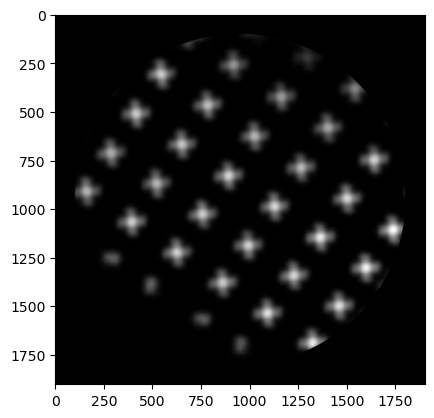

In [13]:
plt.imshow(harris, cmap="gray")
plt.show()

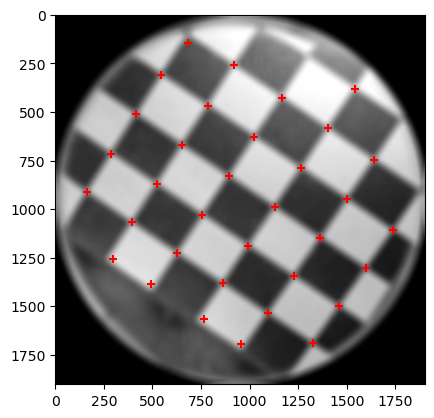

In [14]:
plt.imshow(blur, cmap="gray")
corners = skimage.feature.peak_local_max(harris, min_distance=step, threshold_abs=range/4)
plt.scatter(corners[:, 1], corners[:, 0], color='red', marker="+")
plt.show()

In [15]:
subpix = cv2.cornerSubPix(image=cimg, 
                          corners=corners.reshape(corners.shape[0], 1, 2).astype(np.float32), 
                          winSize=(30,30), 
                          zeroZone=(-1, -1), 
                          criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 300, 0.001)).reshape(corners.shape[0], 2)

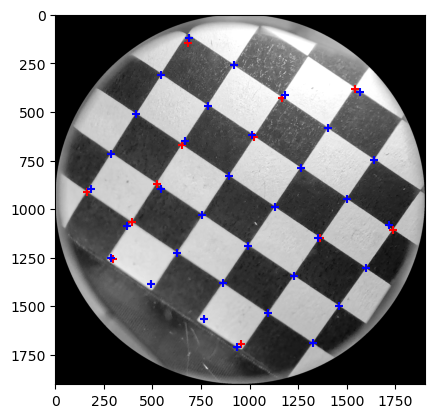

In [16]:
plt.imshow(cimg, cmap="gray")
plt.scatter(corners[:, 1], corners[:, 0], color='red', marker="+")
plt.scatter(subpix[:, 1], subpix[:, 0], color='blue', marker="+")
plt.show()

In [17]:
def apply_harris(cimg):
    blur = cv2.GaussianBlur(cimg, [51, 51], 101)
    harris = cv2.cornerHarris(blur, blockSize=50, ksize=31, k=0.01)
    harris[(xx - harris.shape[1]/2) ** 2 + (yy - harris.shape[0]/2) ** 2 > radius**2] = 0
    range = np.max(harris) - np.min(harris)
    corners = skimage.feature.peak_local_max(harris, min_distance=step, threshold_abs=range/4)
    
    return cv2.cornerSubPix(image=cimg, 
                            corners=corners.reshape(corners.shape[0], 1, 2).astype(np.float32), 
                            winSize=(30,30), 
                            zeroZone=(-1, -1), 
                            criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)).reshape(corners.shape[0], 2)
    

## Checkerboard
Every point lays on a grid. This grid has parameters d_h, d_v (i.e. "vertical" and "horizontal" distance between points in pixels) and \alpha (i.e. rotation angle of this grid). 
Then for every point must exist $[a, b, c_x, c_y]$ such as:

$$
x = a * d_h + c_x
$$
$$
y = b * d_v + c_y
$$

Than apply rotation/inverse rotation on $[x, y]$:

$$ P = R \vec{p} $$


In [18]:
from scipy.optimize import minimize

In [19]:
best_ab = np.zeros((subpix.shape[0], 2))

In [23]:
def err(params):
    dh, dv, cx, cy, slope = params
    angle = np.rad2deg(np.arctan(slope))
    R = cv2.getRotationMatrix2D((cx, cy), angle, 1.0)
    # matrix for homogeneous operation
    R_hom = np.concatenate([R, np.array([0, 0, 1]).reshape(1,3)], axis=0)
    # inverse rotation matrix
    R_inv = np.linalg.inv(R_hom)        
    
    total_err = 0    
    for pid, point in enumerate(subpix):
        # homogeneous coordinates of the point
        point_hom = np.array(point.tolist() + [1])
        # rotated point according to the rotation matrix
        x, y, _ = np.matmul(R_inv, point_hom)
        
        err = np.inf
        ab = [-1, -1]        
        for a in np.arange(0,10): 
            for b in np.arange(0,10):
                current_error = (a * dh - x) ** 2 + (b * dv - y) ** 2
                if current_error < err:
                    ab = np.array([a, b])
                    err = current_error
        
        total_err += err
        best_ab[pid, :] = ab
    
    return total_err
    
result = minimize(err, (250, 200, center[0], center[1], -1), method="Nelder-Mead", options={"maxiter": 10000, "disp": True})
    
# cx, cy, angle = (100, 100, 15)
# R = cv2.getRotationMatrix2D((cx, cy), angle, 1.0)

Optimization terminated successfully.
         Current function value: 12165.468273
         Iterations: 262
         Function evaluations: 451


In [24]:
result

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 12165.468272935645
             x: [ 2.817e+02  2.384e+02  1.338e+03  1.144e+03 -1.479e+00]
           nit: 262
          nfev: 451
 final_simplex: (array([[ 2.817e+02,  2.384e+02, ...,  1.144e+03,
                        -1.479e+00],
                       [ 2.817e+02,  2.384e+02, ...,  1.144e+03,
                        -1.479e+00],
                       ...,
                       [ 2.817e+02,  2.384e+02, ...,  1.144e+03,
                        -1.479e+00],
                       [ 2.817e+02,  2.384e+02, ...,  1.144e+03,
                        -1.479e+00]]), array([ 1.217e+04,  1.217e+04,  1.217e+04,  1.217e+04,
                        1.217e+04,  1.217e+04]))

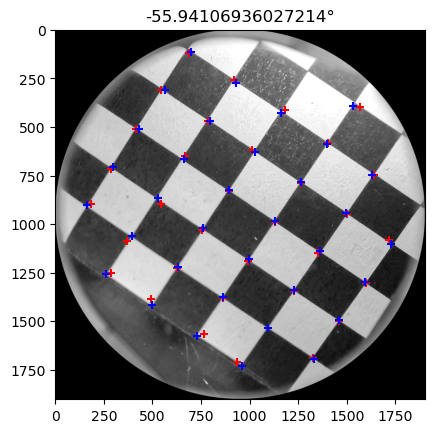

In [25]:
# visualize result
# TODO: fix this visualization ... This does not metter in the following code and calibration. We just needed best_ab which we have.
dh, dv, cx, cy, slope = result.x
angle = np.rad2deg(np.arctan(slope))
R = cv2.getRotationMatrix2D((cx, cy), angle, 1.0)

abpoints = np.matmul(R, np.stack([best_ab[:, 0] * dh, best_ab[:, 1] * dv, np.ones((best_ab.shape[0],))], axis=1).T).T

plt.figure()
plt.imshow(cimg, cmap="gray")
plt.scatter(subpix[:, 1], subpix[:, 0], c='red', marker="+")
plt.scatter(abpoints[:, 1], abpoints[:, 0], c='blue', marker="+")
plt.title(f"{angle}°")
plt.show()

In [26]:
def find_ab(subpix, x0):
    best_ab = np.zeros((subpix.shape[0], 2))
    
    def err(params):
        dh, dv, cx, cy, slope = params
        angle = np.rad2deg(np.arctan(slope))
        R = cv2.getRotationMatrix2D((cx, cy), angle, 1.0)
        # matrix for homogeneous operation
        R_hom = np.concatenate([R, np.array([0, 0, 1]).reshape(1,3)], axis=0)
        # inverse rotation matrix
        R_inv = np.linalg.inv(R_hom)        
        
        total_err = []    
        for pid, point in enumerate(subpix):
            # homogeneous coordinates of the point
            point_hom = np.array(point.tolist() + [1])
            # rotated point according to the rotation matrix
            x, y, _ = np.matmul(R_inv, point_hom)
            
            err = np.inf
            ab = [-1, -1]        
            for a in np.arange(0,10): 
                for b in np.arange(0,10):
                    current_error = (a * dh - x) ** 2 + (b * dv - y) ** 2
                    if current_error < err:
                        ab = np.array([a, b])
                        err = current_error
            
            total_err.append(err)
            best_ab[pid, :] = ab
        
        return np.sum(total_err)
    
    return best_ab, minimize(err, x0, method="Nelder-Mead")

In [27]:
def apply_solution(best_ab, solution):
    dh, dv, cx, cy, slope = solution.x
    angle = np.rad2deg(np.arctan(slope))
    R = cv2.getRotationMatrix2D((cx, cy), angle, 1.0)
    
    abpoints = np.matmul(R, np.stack([best_ab[:, 0] * dh, best_ab[:, 1] * dv, np.ones((best_ab.shape[0],))], axis=1).T).T
    return abpoints, angle


def draw_grid(cimg, subpix, abpoints, angle, err, title=None):    
    plt.figure()
    plt.imshow(cimg, cmap="gray")
    plt.scatter(subpix[:, 1], subpix[:, 0], c='red', marker="+")
    plt.scatter(abpoints[:, 1], abpoints[:, 0], c='blue', marker="+")
    plt.title(f"{title}: {angle:.1f}°, {err:.1f}")
    plt.show()

## Camera calibration
Now we must do this for multiple images, then merge the objpoint to be present on every picure

In [28]:
from tqdm.auto import tqdm
from functools import reduce

  0%|          | 0/56 [00:00<?, ?it/s]

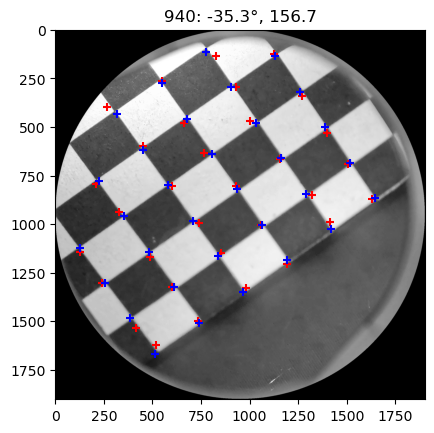

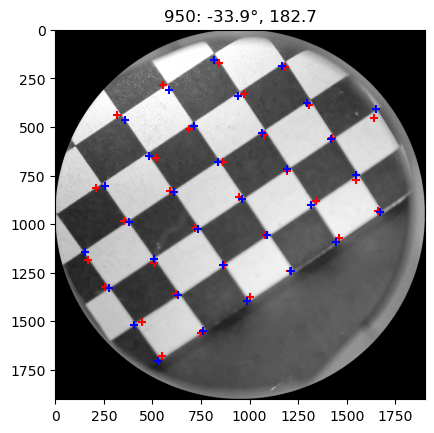

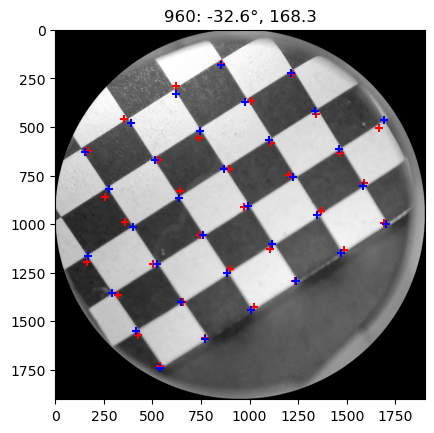

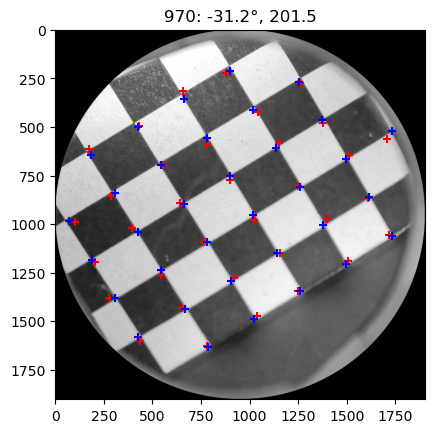

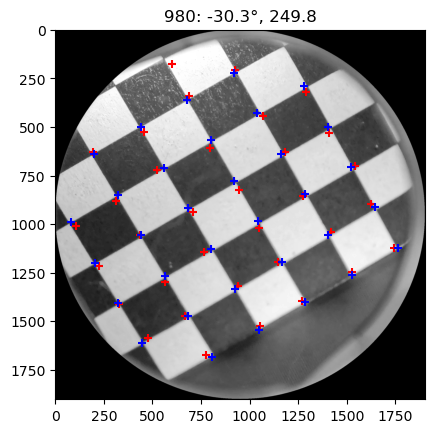

990 failed fun: 125173, point count: 36
1000 failed fun: 270598, point count: 36
1010 failed fun: 172859, point count: 35
1020 failed fun: 246426, point count: 35
1030 failed fun: 324623, point count: 35
1040 failed fun: 278396, point count: 33
1050 failed fun: 272802, point count: 34
1060 failed fun: 299072, point count: 34
1070 failed fun: 257582, point count: 34


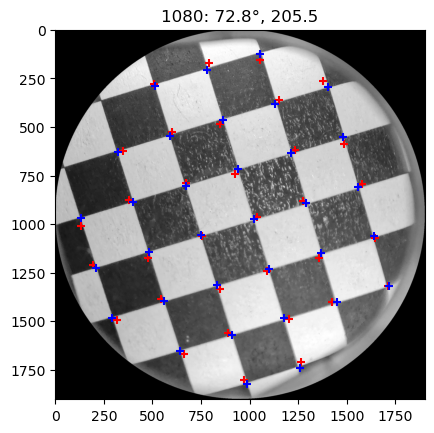

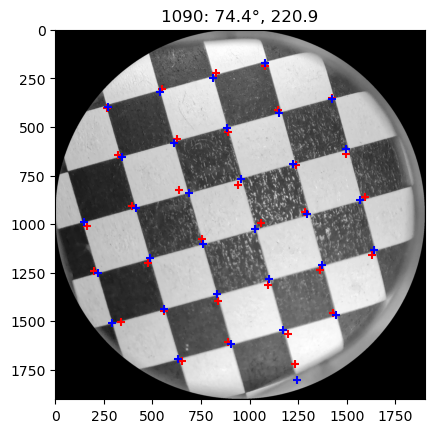

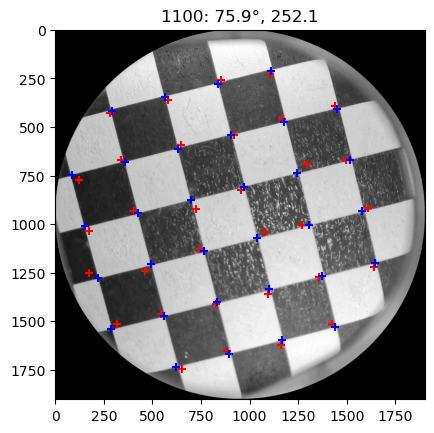

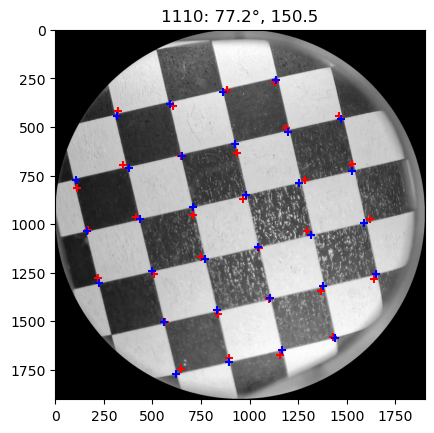

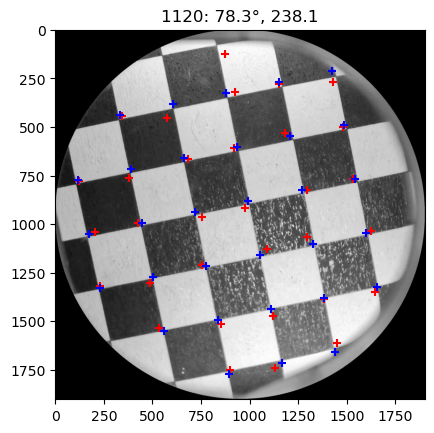

1130 failed fun: 159224, point count: 32
1140 failed fun: 190544, point count: 29
1150 failed fun: 184095, point count: 28


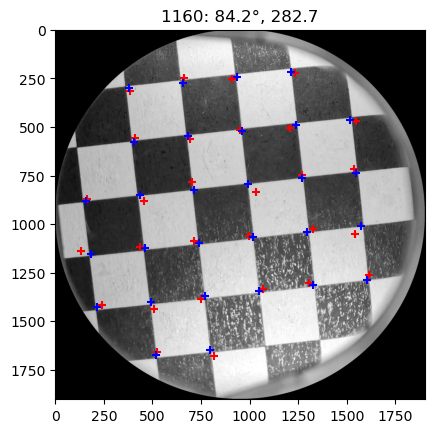

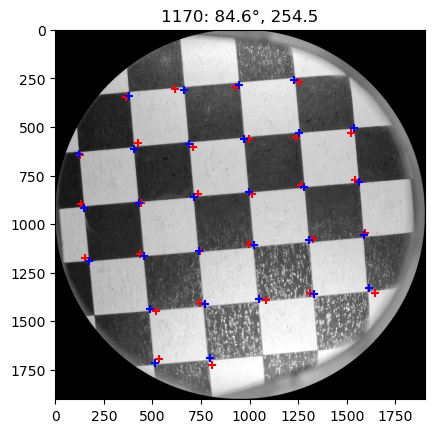

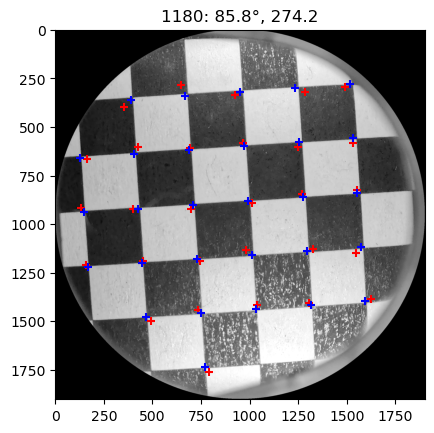

1190 failed fun: 96369, point count: 29
1200 failed fun: 95285, point count: 29


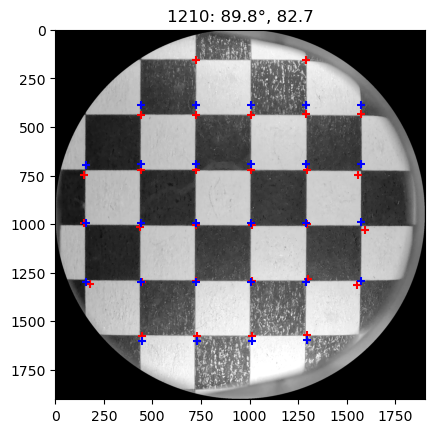

1220 failed fun: 150541, point count: 29
1230 failed fun: 248693, point count: 30
1240 failed fun: 84439, point count: 29
1250 failed fun: 186297, point count: 30
1260 failed fun: 265386, point count: 31
1270 failed fun: 277687, point count: 31
1280 failed fun: 304874, point count: 30
1290 failed fun: 128025, point count: 30
1300 failed fun: 264458, point count: 31
1310 failed fun: 393670, point count: 30
1320 failed fun: 312712, point count: 33
1330 failed fun: 296387, point count: 33
1340 failed fun: 369997, point count: 32
1350 failed fun: 379048, point count: 32
1360 failed fun: 370145, point count: 33
1370 failed fun: 267788, point count: 33
1380 failed fun: 371245, point count: 34
1390 failed fun: 400627, point count: 35
1400 failed fun: 433340, point count: 36
1410 failed fun: 483212, point count: 37
1420 failed fun: 321849, point count: 34
1430 failed fun: 268705, point count: 33
1440 failed fun: 348209, point count: 33
1450 failed fun: 373272, point count: 32
1460 failed fun: 

In [29]:
x0 = np.array([ 2.132e+02,  2.464e+02,  1.239e+03,  1.331e+03, -1e+00])
x0_history = []

frames_ab = []
subpixs = []
frames = []
for frame_no in tqdm(np.arange(940, 1500, 10)):
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_no)
    success, frame = cap.read()
    if not success:
        raise Exception(f"Frame not found in the video {frame_no}")
    
    cimg = crop(frame)    
    subpix = apply_harris(cimg)    
    frame_ab, solution = find_ab(subpix, x0)
    abpoints, angle = apply_solution(frame_ab, solution)

    errs = (abpoints - subpix) ** 2
    
    if np.median(errs) < 300:
        frames.append(frame_no)
        frames_ab.append(frame_ab)
        subpixs.append(subpix)
        x0 = solution.x
        x0_history.append((frame_no, x0))
        draw_grid(cimg, subpix, abpoints, angle, np.median(errs), title=frame_no)
    else:
        x0[4] += step * 2.86330356e-03
        print(f"{frame_no} failed fun: {solution.fun:.0f}, point count: {frame_ab.shape[0]}")

In [448]:
np.polyfit([f[0] for f in x0_history], [f[1][-1] for f in x0_history], 1)

array([ 2.86330356e-03, -3.38572637e+00])

In [56]:
mins = [np.min(fab, 0) for fab in frames_ab]
maxs = [np.max(fab, 0) for fab in frames_ab]
valid_refs = list(reduce(set.intersection, [set((a,b) for a, b in fab - mins[efid]) for efid, fab in enumerate(frames_ab)]))

In [45]:
frames_ab_normalized = [fab - mins[efid] for efid, fab in enumerate(frames_ab)]

In [107]:
objpoints = np.stack([np.concatenate([valid_refs, np.zeros((len(valid_refs), 1))], axis=1)] * len(subpixs), axis=0)
imgpoints = np.zeros((len(subpixs), objpoints.shape[1], 2))
for img_id, (fab, coords) in enumerate(zip(frames_ab_normalized, subpixs)):
    for gid, ab in enumerate(fab):
        try:
            obj_point_id = valid_refs.index(tuple(ab.tolist()))
            imgpoints[img_id, obj_point_id, :] = coords[gid]
        except Exception as e:
            print(e)
            pass

(5.0, 4.0) is not in list
(1.0, 5.0) is not in list
(5.0, 1.0) is not in list
(2.0, 5.0) is not in list
(5.0, 0.0) is not in list
(5.0, 5.0) is not in list
(4.0, 5.0) is not in list
(3.0, 5.0) is not in list
(4.0, 0.0) is not in list
(0.0, 4.0) is not in list
(5.0, 4.0) is not in list
(1.0, 5.0) is not in list
(5.0, 0.0) is not in list
(5.0, 1.0) is not in list
(2.0, 5.0) is not in list
(0.0, 4.0) is not in list
(5.0, 5.0) is not in list
(3.0, 5.0) is not in list
(4.0, 5.0) is not in list
(4.0, 0.0) is not in list
(3.0, 6.0) is not in list
(5.0, 4.0) is not in list
(5.0, 1.0) is not in list
(0.0, 4.0) is not in list
(1.0, 5.0) is not in list
(2.0, 5.0) is not in list
(3.0, 5.0) is not in list
(4.0, 5.0) is not in list
(5.0, 0.0) is not in list
(5.0, 5.0) is not in list
(4.0, 0.0) is not in list
(0.0, 1.0) is not in list
(3.0, 6.0) is not in list
(5.0, 4.0) is not in list
(5.0, 1.0) is not in list
(0.0, 1.0) is not in list
(2.0, 5.0) is not in list
(1.0, 5.0) is not in list
(0.0, 4.0) i

In [110]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints.astype(np.float32),
                    imgpoints.astype(np.float32), 
                    cimg.shape[::-1], None, None)

In [111]:
mtx

array([[2.11380644e+04, 0.00000000e+00, 8.99008723e+02],
       [0.00000000e+00, 1.73666470e+04, 9.20864693e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [112]:
dist

array([[ 7.32368313e+01, -3.34319632e+04, -1.21842601e-01,
        -2.08107859e-01, -8.91144101e+01]])

In [113]:
ret

32.62433361098126